In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Check NumPy version compatibility
if int(np.__version__.split('.')[0]) >= 2:
    print(f"Warning: Detected NumPy {np.__version__}, imgaug is incompatible with NumPy 2.0+")
    print("Solution: Downgrade NumPy to version 1.x")
    print("Run command: pip install 'numpy<2.0'")
    print("Or: pip install numpy==1.26.4")

import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
try:
    from imgaug import augmenters as iaa
except (ImportError, AttributeError) as e:
    if "sctypes" in str(e) or "np.sctypes" in str(e):
        print("\nError: imgaug is incompatible with NumPy 2.0+")
        print("Solution: Downgrade NumPy")
        print("Run command: pip install 'numpy<2.0'")
        print("Or: pip install numpy==1.26.4")
    else:
        print("Warning: imgaug is not installed. Please run: pip install imgaug")
    raise

import random

Found 1964 .bmp files (train: 1464, validate: 500)
Found 500 test .bmp files (test directory exists)
Data shape: x_data=(1964, 356, 328, 1), y_data=(1964, 4)
Image data type: uint8, pixel value range: [0, 255]

Test set loaded: (500, 356, 328, 1), (500, 4)

Training set: (1464, 356, 328, 1), (1464, 4)
Validation set: (500, 356, 328, 1), (500, 4)
Test set: (500, 356, 328, 1), (500, 4)

✓ Training and validation sets are separated to avoid data leakage

Data Count Summary
Training set:
  Number of images: 1464
  Number of labels: 1464
  Image shape: (356, 328, 1) (height, width, channels)
  Label shape: (4,) (4 values per label)

Validation set:
  Number of images: 500
  Number of labels: 500
  Image shape: (356, 328, 1) (height, width, channels)
  Label shape: (4,) (4 values per label)

Total dataset:
  Total images: 1964
  Total labels: 1964


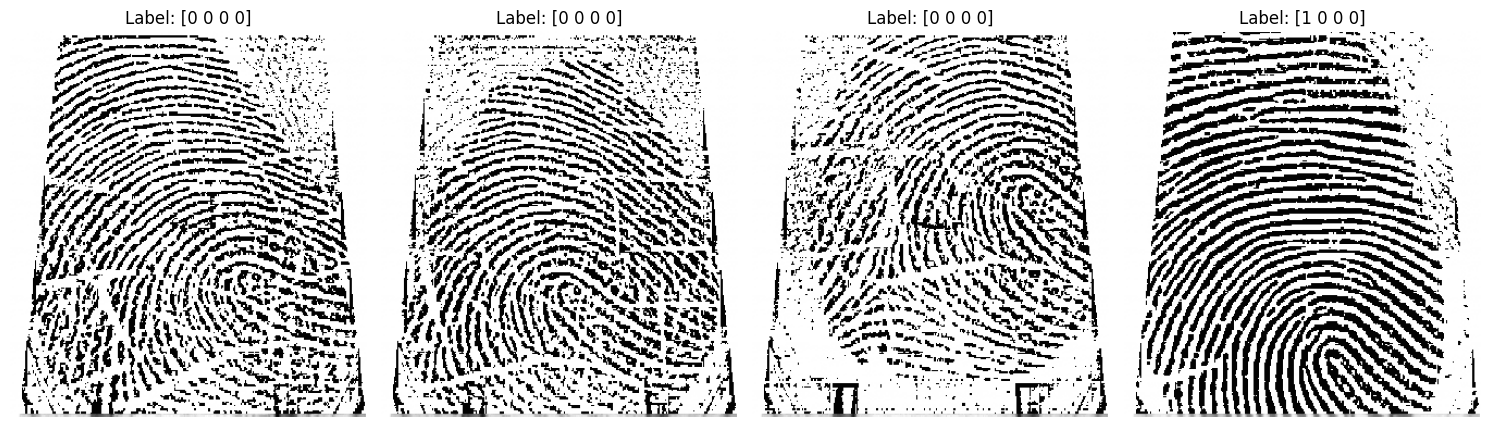

In [26]:
# ============================================
# Load Project-Data Dataset
# ============================================
import os
import glob

def load_project_data(data_dir='Project-Data-Processed-New', img_size=(356, 328)):
    """
    Load Project-Data dataset from .bmp files
    Parameters:
        data_dir: Dataset directory path
        img_size: Target image size (height, width) - already processed to this size
    Returns:
        x_data: Image data array (N, 90, 90, 1) - uint8, [0, 255]
        y_data: Label data array (N, 4) - [subject_id(3), gender(1), left_right(1), finger(1)]
        file_paths: List of file paths corresponding to each image
    """
    import cv2
    
    # Define data directories
    train_dir = os.path.join(data_dir, 'train')
    validate_dir = os.path.join(data_dir, 'validate')
    test_dir = os.path.join(data_dir, 'test')
    
    # Collect all .bmp files
    train_files = sorted(glob.glob(os.path.join(train_dir, '*.bmp')))
    validate_files = sorted(glob.glob(os.path.join(validate_dir, '*.bmp')))
    test_files = sorted(glob.glob(os.path.join(test_dir, '*.bmp'))) if os.path.exists(test_dir) else []
    
    all_files = train_files + validate_files
    print(f"Found {len(all_files)} .bmp files (train: {len(train_files)}, validate: {len(validate_files)})")
    if test_files:
        print(f"Found {len(test_files)} test .bmp files (test directory exists)")
    
    # Store images, labels, and file paths
    images = []
    labels = []
    file_paths = []
    
    for file_path in all_files:
        try:
            # Read preprocessed image from .bmp file (uint8, [0, 255])
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Warning: Unable to read image {file_path}")
                continue
            
            # Verify image shape
            # if img.shape != img_size:
            #     print(f"Warning: Image {file_path} has shape {img.shape}, expected {img_size}")
            #     # Resize if necessary (shouldn't happen if preprocessing was correct)
            #     img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
            
            # Add channel dimension (90, 90) -> (90, 90, 1)
            img = np.expand_dims(img, axis=-1)
            images.append(img)
            file_paths.append(file_path)  # Save file path
            
            # Parse label from filename
            # Filename format: ID_R0_number.bmp or similar
            filename = os.path.basename(file_path)
            filename_no_ext = filename.replace('.bmp', '')
            parts = filename_no_ext.split('_')
            
            if len(parts) >= 1:
                # Extract subject_id (from first part of filename)
                subject_id = int(parts[0])
                # For other information, use default values if not explicitly identified
                # Can be adjusted based on actual filename format
                gender = 0  # Default value, can be adjusted based on actual data
                left_right = 0  # Default value, can be adjusted based on actual data
                finger = 0  # Default value, can be adjusted based on actual data
                
                # If filename contains more information, can parse here
                # For example: if format is ID_Gender_LR_Finger_number
                if len(parts) >= 2:
                    # Can try to extract more information from filename
                    pass
                
                label = np.array([subject_id, gender, left_right, finger], dtype=np.int32)
                labels.append(label)
            else:
                print(f"Warning: Unable to parse filename {filename}")
        except Exception as e:
            print(f"Warning: Unable to load {file_path}: {str(e)}")
            continue
    
    # Convert to numpy arrays
    # Images are uint8 with values in [0, 255] from .bmp files
    x_data = np.array(images, dtype=np.uint8)
    y_data = np.array(labels, dtype=np.int32)
    
    print(f"Data shape: x_data={x_data.shape}, y_data={y_data.shape}")
    print(f"Image data type: {x_data.dtype}, pixel value range: [{x_data.min()}, {x_data.max()}]")
    return x_data, y_data, file_paths

# Load Project-Data dataset
# Note: Keep train and validate directories separated to avoid data leakage
x_data, label_data, file_paths = load_project_data('Project-Data-Processed-New', img_size=(356, 328))

# Method 1: Use train_test_split for random splitting (will mix together)
# x_train, x_val, label_train, label_val = train_test_split(
#     x_data, label_data, test_size=0.2, random_state=42
# )

# Method 2: Separate according to original directory structure (recommended, avoids data leakage)
# From the load_project_data function we know:
# - train_files has 1464 files
# - validate_files has 500 files
# According to loading order, first 1464 are training set, last 500 are validation set
num_train = 1464  # Can be seen from output
x_train = x_data[:num_train]
label_train = label_data[:num_train]
train_file_paths = file_paths[:num_train]  # Save training file paths
x_val = x_data[num_train:]
label_val = label_data[num_train:]
val_file_paths = file_paths[num_train:]  # Save validation file paths

# Load test set if it exists
x_test = None
label_test = None
test_file_paths = None
test_dir = os.path.join('Project-Data-Processed-New', 'test')
if os.path.exists(test_dir):
    test_files = sorted(glob.glob(os.path.join(test_dir, '*.bmp')))
    
    if test_files:
        test_images = []
        test_labels = []
        test_file_paths = []
        
        for file_path in test_files:
            try:
                # Read preprocessed image from .bmp file (uint8, [0, 255])
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    print(f"Warning: Unable to read test image {file_path}")
                    continue
                
                # # Verify image shape
                # if img.shape != (90, 90):
                #     print(f"Warning: Test image {file_path} has shape {img.shape}, expected (90, 90)")
                #     # Resize if necessary (shouldn't happen if preprocessing was correct)
                #     img = cv2.resize(img, (90, 90), interpolation=cv2.INTER_AREA)
                
                # Add channel dimension (90, 90) -> (90, 90, 1)
                img = np.expand_dims(img, axis=-1)
                test_images.append(img)
                test_file_paths.append(file_path)
                
                filename = os.path.basename(file_path)
                filename_no_ext = filename.replace('.bmp', '')
                parts = filename_no_ext.split('_')
                if len(parts) >= 1:
                    subject_id = int(parts[0])
                    label = np.array([subject_id, 0, 0, 0], dtype=np.int32)
                    test_labels.append(label)
            except Exception as e:
                print(f"Warning: Unable to load test file {file_path}: {str(e)}")
                continue
        
        x_test = np.array(test_images, dtype=np.uint8)
        label_test = np.array(test_labels, dtype=np.int32)
        print(f"\nTest set loaded: {x_test.shape}, {label_test.shape}")

print(f"\nTraining set: {x_train.shape}, {label_train.shape}")
print(f"Validation set: {x_val.shape}, {label_val.shape}")
if x_test is not None:
    print(f"Test set: {x_test.shape}, {label_test.shape}")
print(f"\n✓ Training and validation sets are separated to avoid data leakage")

# Print detailed data counts
print("\n" + "="*60)
print("Data Count Summary")
print("="*60)
print(f"Training set:")
print(f"  Number of images: {len(x_train)}")
print(f"  Number of labels: {len(label_train)}")
print(f"  Image shape: {x_train.shape[1:]} (height, width, channels)")
print(f"  Label shape: {label_train.shape[1:]} (4 values per label)")
print(f"\nValidation set:")
print(f"  Number of images: {len(x_val)}")
print(f"  Number of labels: {len(label_val)}")
print(f"  Image shape: {x_val.shape[1:]} (height, width, channels)")
print(f"  Label shape: {label_val.shape[1:]} (4 values per label)")
print(f"\nTotal dataset:")
print(f"  Total images: {len(x_data)}")
print(f"  Total labels: {len(label_data)}")
print("="*60)

# Display some sample images
plt.figure(figsize=(15, 5))
for i in range(min(4, len(x_train))):
    plt.subplot(1, 4, i+1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(f'Label: {label_train[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


# diffrent techique appplied

In [4]:

print("Data information (already loaded and split in Cell 1):")
print(f"Total data: x_data={x_data.shape}, label_data={label_data.shape}")
print(f"Training set: x_train={x_train.shape}, label_train={label_train.shape}")
print(f"Validation set: x_val={x_val.shape}, label_val={label_val.shape}")

Data information (already loaded and split in Cell 1):
Total data: x_data=(1964, 356, 328, 1), label_data=(1964, 4)
Training set: x_train=(1464, 356, 328, 1), label_train=(1464, 4)
Validation set: x_val=(500, 356, 328, 1), label_val=(500, 4)


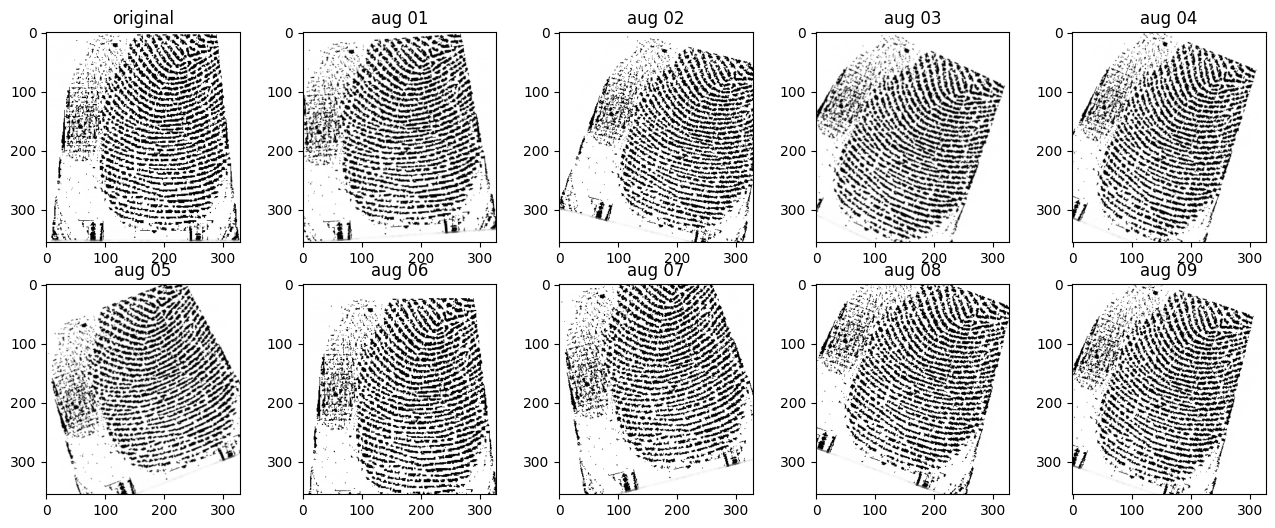

In [5]:
# Use index that actually exists in dataset (avoid index out of bounds)
sample_idx = min(40000, len(x_data) - 1) if len(x_data) > 0 else 0
augs = [x_data[sample_idx]] * 9

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('original')
# Use index that actually exists in dataset (avoid index out of bounds)
sample_idx = min(40000, len(x_data) - 1) if len(x_data) > 0 else 0
plt.imshow(x_data[sample_idx].squeeze(), cmap='gray')
for i, aug in enumerate(augs):
    plt.subplot(2, 5, i+2)
    plt.title('aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

# enhacement

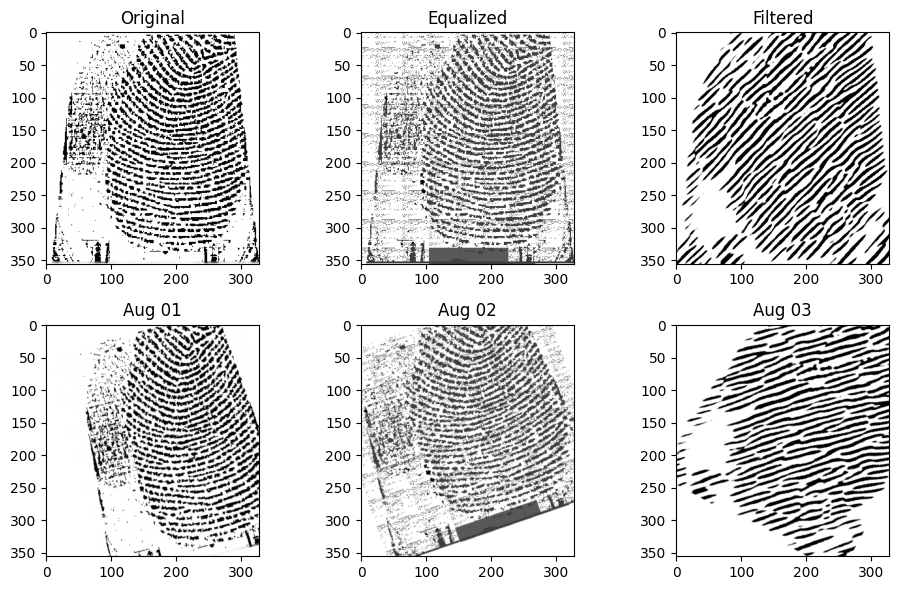

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

# Load the original image (use index that actually exists in dataset)
sample_idx = min(40000, len(x_data) - 1) if len(x_data) > 0 else 0
original_image = x_data[sample_idx]

# Apply histogram equalization to enhance contrast
equalized_image = cv2.equalizeHist(original_image.squeeze())

# Define the parameters for Gabor filtering
ksize = (31, 31)  # Kernel size
sigma = 5.0  # Standard deviation of the Gaussian envelope
theta = np.pi / 4  # Orientation of the Gabor filter (45 degrees)
lambd = 10.0  # Wavelength of the sinusoidal factor
gamma = 0.5  # Spatial aspect ratio
psi = 0.0  # Phase offset

# Create the Gabor filter
gabor_kernel = cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)

# Apply Gabor filtering
filtered_image = cv2.filter2D(original_image.squeeze(), cv2.CV_8UC3, gabor_kernel)

# Create augmentation sequence
seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),  # Blur images with a sigma of 0 to 0.5
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},  # Scale images to 90-110% of their size, individually per axis
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},  # Translate by -10 to +10 percent (per axis)
        rotate=(-30, 30),  # Rotate by -30 to +30 degrees
        order=[0, 1],  # Use nearest neighbor or bilinear interpolation (fast)
        cval=255  # If mode is constant, use a cval between 0 and 255
    )
], random_order=True)

# Apply augmentation to the images
enhanced_augs = seq.augment_images([original_image, equalized_image, filtered_image])

# Plot the original and augmented images
plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('Original')
plt.imshow(original_image.squeeze(), cmap='gray')

plt.subplot(2, 5, 2)
plt.title('Equalized')
plt.imshow(equalized_image.squeeze(), cmap='gray')

plt.subplot(2, 5, 3)
plt.title('Filtered')
plt.imshow(filtered_image.squeeze(), cmap='gray')

for i, aug in enumerate(enhanced_augs):
    plt.subplot(2, 5, i+6)
    plt.title('Aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

plt.tight_layout()
plt.show()


In [ ]:
# ============================================
# Evaluate Matching Accuracy on Validation Set
# ============================================
# Method: Manually calculate accuracy during validation phase
# 1. Get model output distance for each sample
# 2. Compare with ground truth label: same → 1, different → 0
# 3. Determine if distance < threshold matches label == 1 (same person)
# 4. Calculate accuracy, TPR, FPR, TNR, ROC, AUC and other metrics

import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix

def evaluate_contrastive_predictions(model, x_val, label_val, x_real, label_real_dict, 
                                     threshold=None, num_pairs_per_sample=1):
    """
    Evaluate matching accuracy on validation set using threshold-based method
    
    Parameters:
        model: Trained Siamese model (outputs distance)
        x_val: Validation set images
        label_val: Validation set labels
        x_real: Reference images (known identities only)
        label_real_dict: Dictionary mapping label keys to indices in x_real
        threshold: Distance threshold (if None, will be calculated from validation set)
        num_pairs_per_sample: Number of pairs to generate per validation sample
    
    Returns:
        metrics: Dictionary with evaluation metrics
    """
    print("="*70)
    print("Evaluating Matching Accuracy on Validation Set")
    print("="*70)
    
    # Generate pairs: genuine (same person) and impostor (different person)
    y_true = []  # Ground truth: 1 for same person, 0 for different person
    y_pred = []  # Model predictions: distance values
    
    val_keys = []
    for label in label_val:
        key = label.astype(str)
        key = ''.join(key).zfill(6)
        val_keys.append(key)
    
    print("Generating genuine and impostor pairs...")
    genuine_count = 0
    impostor_count = 0
    
    # Generate genuine pairs (same person)
    for i in range(len(x_val)):
        test_img = x_val[i]
        test_key = val_keys[i]
        
        # Only process known identities
        if test_key in label_real_dict:
            ref_idx = label_real_dict[test_key]
            ref_img = x_real[ref_idx]
            
            # Calculate distance
            test_batch = np.expand_dims(test_img.astype(np.float32) / 255.0, axis=0)
            ref_batch = np.expand_dims(ref_img.astype(np.float32) / 255.0, axis=0)
            distance = model.predict([test_batch, ref_batch], verbose=0)[0][0]
            
            y_true.append(1)  # Same person
            y_pred.append(distance)
            genuine_count += 1
    
    # Generate impostor pairs (different person)
    # For each validation sample, compare with a random different reference
    for i in range(len(x_val)):
        test_img = x_val[i]
        test_key = val_keys[i]
        
        # Only process known identities
        if test_key in label_real_dict:
            # Find a different reference image
            while True:
                unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))
                if unmatch_key != test_key:
                    break
            
            ref_img = x_real[unmatch_idx]
            
            # Calculate distance
            test_batch = np.expand_dims(test_img.astype(np.float32) / 255.0, axis=0)
            ref_batch = np.expand_dims(ref_img.astype(np.float32) / 255.0, axis=0)
            distance = model.predict([test_batch, ref_batch], verbose=0)[0][0]
            
            y_true.append(0)  # Different person
            y_pred.append(distance)
            impostor_count += 1
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)  # Distance values (smaller = more similar)
    
    print(f"\nGenerated pairs:")
    print(f"  Genuine pairs (same person): {genuine_count}")
    print(f"  Impostor pairs (different person): {impostor_count}")
    print(f"  Total pairs: {len(y_true)}")
    
    # Calculate optimal threshold if not provided
    if threshold is None:
        print("\nFinding optimal threshold...")
        # Use ROC curve to find optimal threshold (EER)
        try:
            fpr, tpr, thresholds_roc = roc_curve(y_true, -y_pred)  # Negative distance for ROC (larger = more similar)
            fnr = 1 - tpr
            eer_idx = np.nanargmin(np.abs(fpr - fnr))
            threshold = -thresholds_roc[eer_idx]  # Convert back to distance
            eer = fpr[eer_idx]
            print(f"  Optimal threshold (EER): {threshold:.4f}")
            print(f"  EER (Equal Error Rate): {eer:.4f}")
        except ValueError as e:
            print(f"  Warning: Cannot calculate ROC curve: {e}")
            print(f"  Using median distance as threshold")
            threshold = np.median(y_pred) if len(y_pred) > 0 else 0.5
            print(f"  Threshold: {threshold:.4f}")
    else:
        print(f"\nUsing provided threshold: {threshold:.4f}")
    
    # Convert distance predictions to binary predictions
    # distance < threshold → same person (1), distance >= threshold → different person (0)
    y_pred_binary = (y_pred < threshold).astype(int)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred_binary == y_true)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    
    # Calculate metrics
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # True Positive Rate (sensitivity/recall)
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # True Negative Rate (specificity)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0  # False Negative Rate
    
    # Calculate precision, recall, F1
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tpr
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    # Calculate ROC AUC
    try:
        fpr_roc, tpr_roc, _ = roc_curve(y_true, -y_pred)  # Negative distance for ROC
        roc_auc = auc(fpr_roc, tpr_roc)
    except ValueError:
        roc_auc = 0.0
        print("  Warning: Cannot calculate ROC AUC (insufficient classes in y_true)")
    
    print("\n" + "="*70)
    print("Evaluation Results:")
    print("="*70)
    print(f"Threshold: {threshold:.4f}")
    print(f"\nConfusion Matrix:")
    print(f"  True Negatives (TN): {tn}")
    print(f"  False Positives (FP): {fp}")
    print(f"  False Negatives (FN): {fn}")
    print(f"  True Positives (TP): {tp}")
    print(f"\nMetrics:")
    print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  TPR (True Positive Rate / Sensitivity / Recall): {tpr:.4f}")
    print(f"  TNR (True Negative Rate / Specificity): {tnr:.4f}")
    print(f"  FPR (False Positive Rate): {fpr:.4f}")
    print(f"  FNR (False Negative Rate): {fnr:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print("="*70)
    
    # Distance statistics
    genuine_distances = y_pred[y_true == 1]
    impostor_distances = y_pred[y_true == 0]
    
    print(f"\nDistance Statistics:")
    print(f"  Genuine pairs (same person):")
    if len(genuine_distances) > 0:
        print(f"    Mean: {np.mean(genuine_distances):.4f}")
        print(f"    Std: {np.std(genuine_distances):.4f}")
        print(f"    Min: {np.min(genuine_distances):.4f}")
        print(f"    Max: {np.max(genuine_distances):.4f}")
    else:
        print(f"    No genuine pairs found (all test samples are unknown identities)")
    print(f"  Impostor pairs (different person):")
    if len(impostor_distances) > 0:
        print(f"    Mean: {np.mean(impostor_distances):.4f}")
        print(f"    Std: {np.std(impostor_distances):.4f}")
        print(f"    Min: {np.min(impostor_distances):.4f}")
        print(f"    Max: {np.max(impostor_distances):.4f}")
    else:
        print(f"    No impostor pairs found")
    print("="*70)
    
    return {
        'threshold': threshold,
        'accuracy': accuracy,
        'tpr': tpr,
        'tnr': tnr,
        'fpr': fpr,
        'fnr': fnr,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_binary': y_pred_binary,
        'genuine_distances': genuine_distances,
        'impostor_distances': impostor_distances
    }

# Run evaluation
if 'model' in globals() and 'x_val' in globals() and 'label_val' in globals():
    print("Running validation set evaluation...")
    eval_results = evaluate_contrastive_predictions(
        model, x_val, label_val, x_real, label_real_dict,
        threshold=None  # Will calculate optimal threshold automatically
    )
    print(f"\n✓ Validation accuracy: {eval_results['accuracy']:.4f} ({eval_results['accuracy']*100:.2f}%)")
else:
    print("Please run the previous cells first to load data and train the model.")


Please run the previous cells first to load data and train the model.


In [18]:
# ============================================
# Create label_real_dict and x_real for Project-Data
# ============================================
# Important: x_real should only contain training set images to avoid data leakage
# This way, during training and validation, the model won't "see" validation set reference images
label_real_dict = {}
x_real_list = []
y_real_list = []
x_real_file_paths = []  # Store file paths for x_real images

# Use dictionary to track image index for each unique label
# key: label string, value: index in x_real
seen_labels = {}

# Create reference image set using only training set (avoid data leakage)
print("Creating reference image set (using only training set to avoid data leakage)...")
for i, label in enumerate(label_train):
    key = label.astype(str)
    key = ''.join(key).zfill(6)
    
    if key not in seen_labels:
        # Save first image for each unique label as reference
        seen_labels[key] = len(x_real_list)
        label_real_dict[key] = len(x_real_list)
        x_real_list.append(x_train[i])
        y_real_list.append(label)
        x_real_file_paths.append(train_file_paths[i])  # Save corresponding file path
    else:
        # If already exists, update dictionary to point to existing index
        label_real_dict[key] = seen_labels[key]

# Convert to numpy arrays
x_real = np.array(x_real_list, dtype=np.uint8)
y_real = np.array(y_real_list, dtype=np.int32)

print(f"Reference image set (x_real): {x_real.shape}")
print(f"Reference label set (y_real): {y_real.shape}")
print(f"Number of unique labels: {len(seen_labels)}")
print(f"label_real_dict size: {len(label_real_dict)}")

# Verify: Check if all labels in training set are in dictionary
def check_labels_in_dict(labels, label_dict, name):
    """Check if all labels are in dictionary"""
    keys = set()
    for label in labels:
        key = label.astype(str)
        key = ''.join(key).zfill(6)
        keys.add(key)
    
    missing_keys = keys - set(label_dict.keys())
    if missing_keys:
        print(f"Warning: {name} has {len(missing_keys)} labels not in label_real_dict")
        print(f"Example missing keys: {list(missing_keys)[:5]}")
        return False, missing_keys
    else:
        print(f"✓ All labels in {name} are in label_real_dict")
        return True, set()

# Check training set (must all be in dictionary)
train_ok, train_missing = check_labels_in_dict(label_train, label_real_dict, "Training set")

# If there are missing labels, add them from training set
if train_missing:
    print(f"\nFound {len(train_missing)} missing labels, adding from training set...")
    for label in label_train:
        key = label.astype(str)
        key = ''.join(key).zfill(6)
        if key in train_missing and key not in label_real_dict:
            idx = np.where((label_train == label).all(axis=1))[0]
            if len(idx) > 0:
                label_real_dict[key] = len(x_real_list)
                x_real_list.append(x_train[idx[0]])
                y_real_list.append(label)
                x_real_file_paths.append(train_file_paths[idx[0]])  # Save file path
                train_missing.remove(key)
    
    # Update x_real and y_real
    x_real = np.array(x_real_list, dtype=np.uint8)
    y_real = np.array(y_real_list, dtype=np.int32)
    
    # Update file paths if needed (should already be updated in the loop above)
    print(f"Added missing labels, updated x_real shape: {x_real.shape}")
    print(f"Updated label_real_dict size: {len(label_real_dict)}")
    
    # Verify training set again
    train_ok, _ = check_labels_in_dict(label_train, label_real_dict, "Training set")

# Check validation set (validation set may have some new labels not in training set, this is normal)
val_keys = set()
for label in label_val:
    key = label.astype(str)
    key = ''.join(key).zfill(6)
    val_keys.add(key)

val_missing = val_keys - set(label_real_dict.keys())
if val_missing:
    print(f"\nNote: Validation set has {len(val_missing)} labels not in training set")
    print(f"These will be handled using rejection mechanism (threshold-based) during inference")
    print(f"Example unknown labels: {list(val_missing)[:5]}")
else:
    print(f"\n✓ All labels in validation set are in training set (can evaluate completely)")

print("\n" + "="*60)
print("Training Strategy: Only Known Identities")
print("="*60)
print("✓ Model will only train on known identities (no UNKNOWN class)")
print("✓ Unknown fingerprints will be detected using rejection mechanism")
print("  (if similarity with all known identities < threshold, classify as UNKNOWN)")
print("="*60)

Creating reference image set (using only training set to avoid data leakage)...
Reference image set (x_real): (488, 356, 328, 1)
Reference label set (y_real): (488, 4)
Number of unique labels: 488
label_real_dict size: 488
✓ All labels in Training set are in label_real_dict

Note: Validation set has 12 labels not in training set
These will be handled using rejection mechanism (threshold-based) during inference
Example unknown labels: ['320000', '480000', '120000', '200000', '160000']

Training Strategy: Only Known Identities
✓ Model will only train on known identities (no UNKNOWN class)
✓ Unknown fingerprints will be detected using rejection mechanism
  (if similarity with all known identities < threshold, classify as UNKNOWN)


In [10]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True, **kwargs):
        'Initialization'
        super().__init__(**kwargs)  # Newer Keras versions require calling super().__init__()
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Only train on known identities (no UNKNOWN class)
        # Unknown fingerprints will be handled during inference using threshold-based rejection
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 356, 328, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # Data augmentation (applied on-the-fly during training)
        # Note: This is "online augmentation" - images are augmented differently each time
        # The dataset size remains the same (1464), but each epoch sees different variations
        # This effectively increases data diversity without expanding the dataset
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
        
        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        # Only train on known identities - skip unknown fingerprints during training
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            # Only use known fingerprints for training
            # Skip unknown fingerprints (not in label_real_dict) - they will be handled during inference
            if match_key not in self.label_real_dict:
                # For unknown fingerprints, use a random known fingerprint as negative sample
                # This helps model learn to distinguish known from unknown
                unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))
                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.  # Negative sample: this is not a match
            else:
                # Known fingerprint: generate positive or negative sample
                if random.random() > 0.5:
                    # put matched image (positive sample: same fingerprint)
                    x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                    y_batch[i] = 1.
                else:
                    # put unmatched image (negative sample: different fingerprint)
                    while True:
                        unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))
                        if unmatch_key != match_key:
                            break
                    x2_batch[i] = self.x_real[unmatch_idx]
                    y_batch[i] = 0.

        # Ensure return format is tuple and data types are correct
        x1_batch = (x1_batch.astype(np.float32) / 255.)
        x2_batch = (x2_batch.astype(np.float32) / 255.)
        y_batch = y_batch.astype(np.float32)
        return (x1_batch, x2_batch), y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [13]:
# Create data generators
# Only train on known identities - unknown fingerprints will be handled during inference
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=False)

print("="*60)
print("Data Generator Configuration (Threshold-based Rejection)")
print("="*60)
print("Training strategy:")
print("  - Known fingerprints: Compare with matching/non-matching known fingerprints")
print("  - Unknown fingerprints: Skipped during training (will use rejection mechanism in inference)")
print("  - Inference: If similarity with all known identities < threshold -> classify as UNKNOWN")
print("="*60)

Data Generator Configuration (Threshold-based Rejection)
Training strategy:
  - Known fingerprints: Compare with matching/non-matching known fingerprints
  - Unknown fingerprints: Skipped during training (will use rejection mechanism in inference)
  - Inference: If similarity with all known identities < threshold -> classify as UNKNOWN


In [11]:

# ============================================
# Modified Siamese Network: Distance-based with Contrastive Loss
# ============================================
# Architecture:
# - Shared CNN for feature extraction
# - L2 Normalization to maintain interpretable embedding space
# - Euclidean distance as output
# - Contrastive Loss as optimization objective

from keras import backend as K

def contrastive_loss(y_true, y_pred, margin=1.0):
    """
    Contrastive loss function
    y_true: 1 for similar pairs, 0 for dissimilar pairs
    y_pred: Euclidean distance between embeddings
    """
    import tensorflow as tf
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

# Input layers
x1 = layers.Input(shape=(356, 328, 1))
x2 = layers.Input(shape=(356, 328, 1))

# Shared CNN for feature extraction
inputs = layers.Input(shape=(356, 328, 1))

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Flatten()(feature)
feature = layers.Dense(128, activation='relu')(feature)

# L2 Normalization to maintain interpretable embedding space
# Need to specify output_shape for Lambda layer
def l2_normalize_layer(x):
    """
    L2 normalization: x / sqrt(sum(x^2))
    Manual implementation using TensorFlow operations for compatibility
    """
    import tensorflow as tf
    # Calculate L2 norm along axis=1
    # Use expand_dims to maintain shape for broadcasting (instead of keepdims)
    square_sum = tf.reduce_sum(tf.square(x), axis=1)
    l2_norm = tf.sqrt(square_sum + tf.keras.backend.epsilon())
    # Expand dims to match original shape for broadcasting
    l2_norm = tf.expand_dims(l2_norm, axis=1)
    # Normalize by dividing by L2 norm
    return x / l2_norm


feature = layers.Lambda(l2_normalize_layer, output_shape=lambda input_shape: input_shape)(feature)

feature_model = Model(inputs=inputs, outputs=feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)  # Embedding for input 1
x2_net = feature_model(x2)  # Embedding for input 2

# Calculate Euclidean distance between embeddings
# Distance = sqrt(sum((x1 - x2)^2))
def euclidean_distance_layer(inputs):
    import tensorflow as tf
    x1, x2 = inputs
    # Calculate squared difference
    diff_squared = tf.square(x1 - x2)
    # Sum along axis=1 and expand dims for shape (batch_size, 1)
    sum_squared = tf.reduce_sum(diff_squared, axis=1)
    sum_squared = tf.expand_dims(sum_squared, axis=1)
    # Take square root
    return tf.sqrt(sum_squared)

# Output shape function: for multiple inputs, receives list of shapes
# Both inputs have shape (batch_size, 128), output is (batch_size, 1)
def euclidean_output_shape(shapes):
    # shapes is a list: [shape1, shape2]
    # Both shapes are (batch_size, 128), output is (batch_size, 1)
    return (shapes[0][0], 1)

distance = layers.Lambda(euclidean_distance_layer, output_shape=euclidean_output_shape)([x1_net, x2_net])

# Model outputs Euclidean distance (smaller distance = more similar)
model = Model(inputs=[x1, x2], outputs=distance)

# Compile with contrastive loss
model.compile(
    loss=contrastive_loss,
    optimizer='adam',
    metrics=[]  # No accuracy metric for distance output
)

print("="*60)
print("Modified Siamese Network Architecture")
print("="*60)
print("✓ Shared CNN for feature extraction")
print("✓ L2 Normalization to maintain interpretable embedding space")
print("✓ Euclidean distance as output (smaller = more similar)")
print("✓ Contrastive Loss as optimization objective")
print("="*60)
print()

model.summary()

Modified Siamese Network Architecture
✓ Shared CNN for feature extraction
✓ L2 Normalization to maintain interpretable embedding space
✓ Euclidean distance as output (smaller = more similar)
✓ Contrastive Loss as optimization objective



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 356, 328,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 356, 328,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │ 29,902,304 │ input_layer[0][0… │
│ (Functional)        │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,902,304 (114.07 MB)

 Trainable params: 29,902,304 (114.07 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# ============================================
# Training with Checkpoint Saving
# ============================================
import os
from keras.callbacks import ModelCheckpoint

# Create checkpoints directory if it doesn't exist
checkpoint_dir = 'checkpoints/preprocessing'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define checkpoint callback
# Save the best model based on validation loss
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'siamese_model_best.h5'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

# Also save checkpoint after each epoch (optional, for recovery)
checkpoint_each_epoch = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'siamese_model_epoch_{epoch:03d}_val_loss_{val_loss:.4f}.h5'),
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False,
    verbose=0
)

print("="*60)
print("Starting Training with Checkpoint Saving")
print("="*60)
print(f"Checkpoint directory: {checkpoint_dir}/")
print(f"Best model will be saved to: {checkpoint_dir}/siamese_model_best.h5")
print("="*60)
print()

# Train the model
history = model.fit(
    train_gen, 
    epochs=100, 
    validation_data=val_gen,
    callbacks=[checkpoint_callback, checkpoint_each_epoch]
)

# Save final model (after all epochs)
final_model_path = os.path.join(checkpoint_dir, 'siamese_model_final.h5')
model.save(final_model_path)
print(f"\n✓ Final model saved to: {final_model_path}")

# Save training history
import json
history_dict = {key: [float(val) for val in values] for key, values in history.history.items()}
history_path = os.path.join(checkpoint_dir, 'training_history.json')
with open(history_path, 'w') as f:
    json.dump(history_dict, f, indent=2)
print(f"✓ Training history saved to: {history_path}")

print("\n" + "="*60)
print("Training Completed!")
print("="*60)
print(f"Best model: {checkpoint_dir}/siamese_model_best.h5")
print(f"Final model: {final_model_path}")
print(f"Training history: {history_path}")
print("="*60)

Starting Training with Checkpoint Saving
Checkpoint directory: checkpoints/preprocessing/
Best model will be saved to: checkpoints/preprocessing/siamese_model_best.h5

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - loss: 0.3487
Epoch 1: val_loss improved from inf to 0.29218, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 22s 468ms/step - loss: 0.3475 - val_loss: 0.2922
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - loss: 0.2554
Epoch 2: val_loss improved from 0.29218 to 0.27181, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - loss: 0.2554 - val_loss: 0.2718
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - loss: 0.2587
Epoch 3: val_loss did not improve from 0.27181


45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - loss: 0.2586 - val_loss: 0.2744
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - loss: 0.2465
Epoch 4: val_loss improved from 0.27181 to 0.25873, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 462ms/step - loss: 0.2464 - val_loss: 0.2587
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - loss: 0.2320
Epoch 5: val_loss improved from 0.25873 to 0.24936, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 464ms/step - loss: 0.2320 - val_loss: 0.2494
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - loss: 0.2236
Epoch 6: val_loss improved from 0.24936 to 0.24269, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 441ms/step - loss: 0.2235 - val_loss: 0.2427
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - loss: 0.2024
Epoch 7: val_loss improved from 0.24269 to 0.20156, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step - loss: 0.2024 - val_loss: 0.2016
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - loss: 0.1868
Epoch 8: val_loss did not improve from 0.20156


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step - loss: 0.1870 - val_loss: 0.2062
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - loss: 0.1844
Epoch 9: val_loss improved from 0.20156 to 0.19953, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 435ms/step - loss: 0.1844 - val_loss: 0.1995
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - loss: 0.1901
Epoch 10: val_loss improved from 0.19953 to 0.19939, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 445ms/step - loss: 0.1901 - val_loss: 0.1994
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - loss: 0.1775
Epoch 11: val_loss did not improve from 0.19939


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 441ms/step - loss: 0.1775 - val_loss: 0.2028
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - loss: 0.1784
Epoch 12: val_loss did not improve from 0.19939


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - loss: 0.1784 - val_loss: 0.2029
Epoch 13/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - loss: 0.1725
Epoch 13: val_loss did not improve from 0.19939


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 442ms/step - loss: 0.1726 - val_loss: 0.2008
Epoch 14/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - loss: 0.1675
Epoch 14: val_loss did not improve from 0.19939


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 440ms/step - loss: 0.1675 - val_loss: 0.2048
Epoch 15/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - loss: 0.1819
Epoch 15: val_loss did not improve from 0.19939


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 447ms/step - loss: 0.1818 - val_loss: 0.2005
Epoch 16/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - loss: 0.1723
Epoch 16: val_loss improved from 0.19939 to 0.19455, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step - loss: 0.1722 - val_loss: 0.1946
Epoch 17/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - loss: 0.1710
Epoch 17: val_loss did not improve from 0.19455


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 440ms/step - loss: 0.1710 - val_loss: 0.1964
Epoch 18/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - loss: 0.1655
Epoch 18: val_loss did not improve from 0.19455


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - loss: 0.1657 - val_loss: 0.2136
Epoch 19/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - loss: 0.1706
Epoch 19: val_loss improved from 0.19455 to 0.19355, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - loss: 0.1706 - val_loss: 0.1936
Epoch 20/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - loss: 0.1640
Epoch 20: val_loss did not improve from 0.19355


45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 432ms/step - loss: 0.1640 - val_loss: 0.2018
Epoch 21/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - loss: 0.1630
Epoch 21: val_loss did not improve from 0.19355


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 441ms/step - loss: 0.1630 - val_loss: 0.1953
Epoch 22/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - loss: 0.1654
Epoch 22: val_loss did not improve from 0.19355


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 446ms/step - loss: 0.1654 - val_loss: 0.1977
Epoch 23/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - loss: 0.1588
Epoch 23: val_loss improved from 0.19355 to 0.18211, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 459ms/step - loss: 0.1589 - val_loss: 0.1821
Epoch 24/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - loss: 0.1620
Epoch 24: val_loss did not improve from 0.18211


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 440ms/step - loss: 0.1621 - val_loss: 0.1920
Epoch 25/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - loss: 0.1615
Epoch 25: val_loss did not improve from 0.18211


45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 433ms/step - loss: 0.1615 - val_loss: 0.2097
Epoch 26/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - loss: 0.1579
Epoch 26: val_loss did not improve from 0.18211


45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 432ms/step - loss: 0.1579 - val_loss: 0.1959
Epoch 27/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - loss: 0.1606
Epoch 27: val_loss did not improve from 0.18211


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 440ms/step - loss: 0.1606 - val_loss: 0.1931
Epoch 28/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - loss: 0.1536
Epoch 28: val_loss did not improve from 0.18211


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 439ms/step - loss: 0.1536 - val_loss: 0.1876
Epoch 29/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - loss: 0.1548
Epoch 29: val_loss improved from 0.18211 to 0.18134, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 441ms/step - loss: 0.1548 - val_loss: 0.1813
Epoch 30/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - loss: 0.1562
Epoch 30: val_loss did not improve from 0.18134


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 437ms/step - loss: 0.1563 - val_loss: 0.1975
Epoch 31/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - loss: 0.1586
Epoch 31: val_loss did not improve from 0.18134


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 442ms/step - loss: 0.1586 - val_loss: 0.1872
Epoch 32/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - loss: 0.1544
Epoch 32: val_loss did not improve from 0.18134


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 452ms/step - loss: 0.1545 - val_loss: 0.1866
Epoch 33/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - loss: 0.1453
Epoch 33: val_loss did not improve from 0.18134


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 435ms/step - loss: 0.1454 - val_loss: 0.1925
Epoch 34/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - loss: 0.1584
Epoch 34: val_loss did not improve from 0.18134


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - loss: 0.1583 - val_loss: 0.1938
Epoch 35/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - loss: 0.1518
Epoch 35: val_loss did not improve from 0.18134


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 439ms/step - loss: 0.1519 - val_loss: 0.1884
Epoch 36/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - loss: 0.1542
Epoch 36: val_loss did not improve from 0.18134


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step - loss: 0.1542 - val_loss: 0.1848
Epoch 37/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - loss: 0.1513
Epoch 37: val_loss did not improve from 0.18134


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 443ms/step - loss: 0.1513 - val_loss: 0.2001
Epoch 38/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - loss: 0.1512
Epoch 38: val_loss did not improve from 0.18134


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step - loss: 0.1513 - val_loss: 0.1876
Epoch 39/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - loss: 0.1658
Epoch 39: val_loss did not improve from 0.18134


45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 464ms/step - loss: 0.1657 - val_loss: 0.1822
Epoch 40/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - loss: 0.1538
Epoch 40: val_loss did not improve from 0.18134


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step - loss: 0.1538 - val_loss: 0.1865
Epoch 41/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - loss: 0.1479
Epoch 41: val_loss did not improve from 0.18134


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 451ms/step - loss: 0.1479 - val_loss: 0.1822
Epoch 42/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - loss: 0.1397
Epoch 42: val_loss improved from 0.18134 to 0.17950, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 453ms/step - loss: 0.1399 - val_loss: 0.1795
Epoch 43/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - loss: 0.1502
Epoch 43: val_loss did not improve from 0.17950


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 445ms/step - loss: 0.1501 - val_loss: 0.1912
Epoch 44/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - loss: 0.1528
Epoch 44: val_loss did not improve from 0.17950


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - loss: 0.1527 - val_loss: 0.1831
Epoch 45/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - loss: 0.1481
Epoch 45: val_loss did not improve from 0.17950


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 452ms/step - loss: 0.1481 - val_loss: 0.1905
Epoch 46/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - loss: 0.1444
Epoch 46: val_loss improved from 0.17950 to 0.17525, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 460ms/step - loss: 0.1445 - val_loss: 0.1752
Epoch 47/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - loss: 0.1386
Epoch 47: val_loss did not improve from 0.17525


45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 461ms/step - loss: 0.1387 - val_loss: 0.1938
Epoch 48/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - loss: 0.1464
Epoch 48: val_loss did not improve from 0.17525


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 445ms/step - loss: 0.1465 - val_loss: 0.1926
Epoch 49/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - loss: 0.1514
Epoch 49: val_loss improved from 0.17525 to 0.17070, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - loss: 0.1513 - val_loss: 0.1707
Epoch 50/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - loss: 0.1429
Epoch 50: val_loss did not improve from 0.17070


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 442ms/step - loss: 0.1430 - val_loss: 0.1842
Epoch 51/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - loss: 0.1437
Epoch 51: val_loss did not improve from 0.17070


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 453ms/step - loss: 0.1437 - val_loss: 0.1792
Epoch 52/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - loss: 0.1461
Epoch 52: val_loss improved from 0.17070 to 0.16524, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - loss: 0.1462 - val_loss: 0.1652
Epoch 53/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - loss: 0.1445
Epoch 53: val_loss did not improve from 0.16524


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 454ms/step - loss: 0.1445 - val_loss: 0.1898
Epoch 54/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - loss: 0.1431
Epoch 54: val_loss did not improve from 0.16524


45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - loss: 0.1432 - val_loss: 0.1884
Epoch 55/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - loss: 0.1331
Epoch 55: val_loss did not improve from 0.16524


45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 459ms/step - loss: 0.1332 - val_loss: 0.1806
Epoch 56/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - loss: 0.1378
Epoch 56: val_loss did not improve from 0.16524


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 452ms/step - loss: 0.1378 - val_loss: 0.1763
Epoch 57/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - loss: 0.1359
Epoch 57: val_loss did not improve from 0.16524


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - loss: 0.1360 - val_loss: 0.1775
Epoch 58/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - loss: 0.1405
Epoch 58: val_loss did not improve from 0.16524


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - loss: 0.1406 - val_loss: 0.1754
Epoch 59/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - loss: 0.1371
Epoch 59: val_loss did not improve from 0.16524


45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 466ms/step - loss: 0.1372 - val_loss: 0.1690
Epoch 60/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - loss: 0.1292
Epoch 60: val_loss did not improve from 0.16524


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 454ms/step - loss: 0.1294 - val_loss: 0.1712
Epoch 61/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - loss: 0.1423
Epoch 61: val_loss did not improve from 0.16524


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - loss: 0.1423 - val_loss: 0.1674
Epoch 62/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - loss: 0.1318
Epoch 62: val_loss improved from 0.16524 to 0.16390, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 464ms/step - loss: 0.1319 - val_loss: 0.1639
Epoch 63/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - loss: 0.1377
Epoch 63: val_loss did not improve from 0.16390


45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 459ms/step - loss: 0.1376 - val_loss: 0.1666
Epoch 64/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - loss: 0.1350
Epoch 64: val_loss did not improve from 0.16390


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 455ms/step - loss: 0.1350 - val_loss: 0.1811
Epoch 65/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - loss: 0.1353
Epoch 65: val_loss improved from 0.16390 to 0.15566, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 452ms/step - loss: 0.1353 - val_loss: 0.1557
Epoch 66/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - loss: 0.1338
Epoch 66: val_loss did not improve from 0.15566


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 445ms/step - loss: 0.1339 - val_loss: 0.1684
Epoch 67/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - loss: 0.1361
Epoch 67: val_loss did not improve from 0.15566


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step - loss: 0.1360 - val_loss: 0.1557
Epoch 68/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - loss: 0.1398
Epoch 68: val_loss did not improve from 0.15566


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 439ms/step - loss: 0.1397 - val_loss: 0.1690
Epoch 69/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - loss: 0.1326
Epoch 69: val_loss did not improve from 0.15566


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step - loss: 0.1326 - val_loss: 0.1651
Epoch 70/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - loss: 0.1244
Epoch 70: val_loss did not improve from 0.15566


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 446ms/step - loss: 0.1244 - val_loss: 0.1614
Epoch 71/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - loss: 0.1305
Epoch 71: val_loss improved from 0.15566 to 0.15537, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 445ms/step - loss: 0.1305 - val_loss: 0.1554
Epoch 72/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - loss: 0.1243
Epoch 72: val_loss did not improve from 0.15537


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step - loss: 0.1245 - val_loss: 0.1683
Epoch 73/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - loss: 0.1305
Epoch 73: val_loss did not improve from 0.15537


45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 433ms/step - loss: 0.1306 - val_loss: 0.1585
Epoch 74/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - loss: 0.1206
Epoch 74: val_loss did not improve from 0.15537


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 446ms/step - loss: 0.1206 - val_loss: 0.1644
Epoch 75/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - loss: 0.1282
Epoch 75: val_loss did not improve from 0.15537


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 446ms/step - loss: 0.1282 - val_loss: 0.1559
Epoch 76/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - loss: 0.1388
Epoch 76: val_loss did not improve from 0.15537


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step - loss: 0.1387 - val_loss: 0.1556
Epoch 77/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - loss: 0.1314
Epoch 77: val_loss improved from 0.15537 to 0.14767, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 454ms/step - loss: 0.1314 - val_loss: 0.1477
Epoch 78/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - loss: 0.1307
Epoch 78: val_loss did not improve from 0.14767


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 439ms/step - loss: 0.1307 - val_loss: 0.1580
Epoch 79/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - loss: 0.1314
Epoch 79: val_loss did not improve from 0.14767


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 445ms/step - loss: 0.1313 - val_loss: 0.1588
Epoch 80/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - loss: 0.1315
Epoch 80: val_loss did not improve from 0.14767


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 451ms/step - loss: 0.1315 - val_loss: 0.1567
Epoch 81/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - loss: 0.1282
Epoch 81: val_loss did not improve from 0.14767


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 445ms/step - loss: 0.1282 - val_loss: 0.1563
Epoch 82/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - loss: 0.1237
Epoch 82: val_loss improved from 0.14767 to 0.14760, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 450ms/step - loss: 0.1237 - val_loss: 0.1476
Epoch 83/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - loss: 0.1191
Epoch 83: val_loss improved from 0.14760 to 0.14451, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 445ms/step - loss: 0.1190 - val_loss: 0.1445
Epoch 84/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - loss: 0.1264
Epoch 84: val_loss did not improve from 0.14451


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 446ms/step - loss: 0.1265 - val_loss: 0.1552
Epoch 85/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - loss: 0.1210
Epoch 85: val_loss did not improve from 0.14451


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - loss: 0.1211 - val_loss: 0.1618
Epoch 86/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - loss: 0.1330
Epoch 86: val_loss did not improve from 0.14451


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 443ms/step - loss: 0.1329 - val_loss: 0.1468
Epoch 87/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - loss: 0.1193
Epoch 87: val_loss improved from 0.14451 to 0.14138, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step - loss: 0.1194 - val_loss: 0.1414
Epoch 88/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - loss: 0.1201
Epoch 88: val_loss did not improve from 0.14138


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 441ms/step - loss: 0.1201 - val_loss: 0.1518
Epoch 89/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - loss: 0.1288
Epoch 89: val_loss did not improve from 0.14138


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step - loss: 0.1287 - val_loss: 0.1470
Epoch 90/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - loss: 0.1190
Epoch 90: val_loss did not improve from 0.14138


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 439ms/step - loss: 0.1191 - val_loss: 0.1488
Epoch 91/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - loss: 0.1180
Epoch 91: val_loss did not improve from 0.14138


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 442ms/step - loss: 0.1181 - val_loss: 0.1473
Epoch 92/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - loss: 0.1238
Epoch 92: val_loss did not improve from 0.14138


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 456ms/step - loss: 0.1238 - val_loss: 0.1529
Epoch 93/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - loss: 0.1258
Epoch 93: val_loss did not improve from 0.14138


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - loss: 0.1257 - val_loss: 0.1461
Epoch 94/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - loss: 0.1218
Epoch 94: val_loss improved from 0.14138 to 0.14055, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 476ms/step - loss: 0.1218 - val_loss: 0.1405
Epoch 95/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - loss: 0.1219
Epoch 95: val_loss did not improve from 0.14055


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 446ms/step - loss: 0.1219 - val_loss: 0.1485
Epoch 96/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - loss: 0.1382
Epoch 96: val_loss improved from 0.14055 to 0.13976, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 450ms/step - loss: 0.1379 - val_loss: 0.1398
Epoch 97/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - loss: 0.1232
Epoch 97: val_loss improved from 0.13976 to 0.13665, saving model to checkpoints/preprocessing/siamese_model_best.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 446ms/step - loss: 0.1232 - val_loss: 0.1366
Epoch 98/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - loss: 0.1093
Epoch 98: val_loss did not improve from 0.13665


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 449ms/step - loss: 0.1095 - val_loss: 0.1593
Epoch 99/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - loss: 0.1175
Epoch 99: val_loss did not improve from 0.13665


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 440ms/step - loss: 0.1176 - val_loss: 0.1471
Epoch 100/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - loss: 0.1242
Epoch 100: val_loss did not improve from 0.13665


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step - loss: 0.1241 - val_loss: 0.1469



✓ Final model saved to: checkpoints/preprocessing/siamese_model_final.h5
✓ Training history saved to: checkpoints/preprocessing/training_history.json

Training Completed!
Best model: checkpoints/preprocessing/siamese_model_best.h5
Final model: checkpoints/preprocessing/siamese_model_final.h5
Training history: checkpoints/preprocessing/training_history.json


In [15]:
# ============================================
# Load Saved Model (Optional)
# ============================================
# Use this cell to load a previously saved model instead of training from scratch

import os
from keras.models import load_model

# Define the checkpoint directory
checkpoint_dir = 'checkpoints'

# Choose which model to load:
# Option 1: Load the best model (lowest validation loss)
best_model_path = os.path.join(checkpoint_dir, 'siamese_model_best.h5')

# Option 2: Load the final model (after all epochs)
final_model_path = os.path.join(checkpoint_dir, 'siamese_model_final.h5')

# Option 3: Load a specific epoch checkpoint
# specific_epoch_path = os.path.join(checkpoint_dir, 'siamese_model_epoch_050_val_loss_0.2000.h5')

# Load the model
if os.path.exists(best_model_path):
    print("="*60)
    print("Loading Saved Model")
    print("="*60)
    print(f"Loading best model from: {best_model_path}")
    
    # Note: If you have custom loss function (contrastive_loss), you need to provide it
    # when loading the model
    from keras import backend as K
    import tensorflow as tf
    
    def contrastive_loss(y_true, y_pred, margin=1.0):
        """Contrastive loss function (must match the one used during training)"""
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)
    
    # Load model with custom loss
    model = load_model(best_model_path, custom_objects={'contrastive_loss': contrastive_loss})
    
    print("✓ Model loaded successfully!")
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
    print("="*60)
    
    # Optionally load training history
    history_path = os.path.join(checkpoint_dir, 'training_history.json')
    if os.path.exists(history_path):
        import json
        with open(history_path, 'r') as f:
            training_history = json.load(f)
        print(f"\n✓ Training history loaded from: {history_path}")
        print(f"  Training epochs: {len(training_history.get('loss', []))}")
        if 'val_loss' in training_history:
            best_val_loss = min(training_history['val_loss'])
            best_epoch = training_history['val_loss'].index(best_val_loss) + 1
            print(f"  Best validation loss: {best_val_loss:.4f} (epoch {best_epoch})")
else:
    print("="*60)
    print("No Saved Model Found")
    print("="*60)
    print(f"Checkpoint directory '{checkpoint_dir}' does not exist or is empty.")
    print("Please run Cell 12 to train and save the model first.")
    print("="*60)


Loading Saved Model
Loading best model from: checkpoints/siamese_model_best.h5


TypeError: Could not locate function 'l2_normalize_layer'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'l2_normalize_layer', 'registered_name': 'function'}

In [21]:
# ============================================
# Evaluate Matching Accuracy on Validation Set
# ============================================
# Method: Manually calculate accuracy during validation phase
# 1. Get model output distance for each sample
# 2. Compare with ground truth label: same → 1, different → 0
# 3. Determine if distance < threshold matches label == 1 (same person)
# 4. Calculate accuracy, TPR, FPR, TNR, ROC, AUC and other metrics

import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix

def evaluate_contrastive_predictions(model, x_val, label_val, x_real, label_real_dict, 
                                     threshold=None, num_pairs_per_sample=1):
    """
    Evaluate matching accuracy on validation set using threshold-based method
    
    Parameters:
        model: Trained Siamese model (outputs distance)
        x_val: Validation set images
        label_val: Validation set labels
        x_real: Reference images (known identities only)
        label_real_dict: Dictionary mapping label keys to indices in x_real
        threshold: Distance threshold (if None, will be calculated from validation set)
        num_pairs_per_sample: Number of pairs to generate per validation sample
    
    Returns:
        metrics: Dictionary with evaluation metrics
    """
    print("="*70)
    print("Evaluating Matching Accuracy on Validation Set")
    print("="*70)
    
    # Generate pairs: genuine (same person) and impostor (different person)
    y_true = []  # Ground truth: 1 for same person, 0 for different person
    y_pred = []  # Model predictions: distance values
    
    val_keys = []
    for label in label_val:
        key = label.astype(str)
        key = ''.join(key).zfill(6)
        val_keys.append(key)
    
    print("Generating genuine and impostor pairs...")
    genuine_count = 0
    impostor_count = 0
    
    # Generate genuine pairs (same person)
    for i in range(len(x_val)):
        test_img = x_val[i]
        test_key = val_keys[i]
        
        # Only process known identities
        if test_key in label_real_dict:
            ref_idx = label_real_dict[test_key]
            ref_img = x_real[ref_idx]
            
            # Calculate distance
            test_batch = np.expand_dims(test_img.astype(np.float32) / 255.0, axis=0)
            ref_batch = np.expand_dims(ref_img.astype(np.float32) / 255.0, axis=0)
            distance = model.predict([test_batch, ref_batch], verbose=0)[0][0]
            
            y_true.append(1)  # Same person
            y_pred.append(distance)
            genuine_count += 1
    
    # Generate impostor pairs (different person)
    # For each validation sample, compare with a random different reference
    for i in range(len(x_val)):
        test_img = x_val[i]
        test_key = val_keys[i]
        
        # Only process known identities
        if test_key in label_real_dict:
            # Find a different reference image
            while True:
                unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))
                if unmatch_key != test_key:
                    break
            
            ref_img = x_real[unmatch_idx]
            
            # Calculate distance
            test_batch = np.expand_dims(test_img.astype(np.float32) / 255.0, axis=0)
            ref_batch = np.expand_dims(ref_img.astype(np.float32) / 255.0, axis=0)
            distance = model.predict([test_batch, ref_batch], verbose=0)[0][0]
            
            y_true.append(0)  # Different person
            y_pred.append(distance)
            impostor_count += 1
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)  # Distance values (smaller = more similar)
    
    print(f"\nGenerated pairs:")
    print(f"  Genuine pairs (same person): {genuine_count}")
    print(f"  Impostor pairs (different person): {impostor_count}")
    print(f"  Total pairs: {len(y_true)}")
    
    # Calculate optimal threshold if not provided
    if threshold is None:
        print("\nFinding optimal threshold...")
        # Use ROC curve to find optimal threshold (EER)
        try:
            fpr, tpr, thresholds_roc = roc_curve(y_true, -y_pred)  # Negative distance for ROC (larger = more similar)
            fnr = 1 - tpr
            eer_idx = np.nanargmin(np.abs(fpr - fnr))
            threshold = -thresholds_roc[eer_idx]  # Convert back to distance
            eer = fpr[eer_idx]
            print(f"  Optimal threshold (EER): {threshold:.4f}")
            print(f"  EER (Equal Error Rate): {eer:.4f}")
        except ValueError as e:
            print(f"  Warning: Cannot calculate ROC curve: {e}")
            print(f"  Using median distance as threshold")
            threshold = np.median(y_pred) if len(y_pred) > 0 else 0.5
            print(f"  Threshold: {threshold:.4f}")
    else:
        print(f"\nUsing provided threshold: {threshold:.4f}")
    
    # Convert distance predictions to binary predictions
    # distance < threshold → same person (1), distance >= threshold → different person (0)
    y_pred_binary = (y_pred < threshold).astype(int)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred_binary == y_true)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    
    # Calculate metrics
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # True Positive Rate (sensitivity/recall)
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # True Negative Rate (specificity)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0  # False Positive Rate
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0  # False Negative Rate
    
    # Calculate precision, recall, F1
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tpr
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    # Calculate ROC AUC
    try:
        fpr_roc, tpr_roc, _ = roc_curve(y_true, -y_pred)  # Negative distance for ROC
        roc_auc = auc(fpr_roc, tpr_roc)
    except ValueError:
        roc_auc = 0.0
        print("  Warning: Cannot calculate ROC AUC (insufficient classes in y_true)")
    
    print("\n" + "="*70)
    print("Evaluation Results:")
    print("="*70)
    print(f"Threshold: {threshold:.4f}")
    print(f"\nConfusion Matrix:")
    print(f"  True Negatives (TN): {tn}")
    print(f"  False Positives (FP): {fp}")
    print(f"  False Negatives (FN): {fn}")
    print(f"  True Positives (TP): {tp}")
    print(f"\nMetrics:")
    print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  TPR (True Positive Rate / Sensitivity / Recall): {tpr:.4f}")
    print(f"  TNR (True Negative Rate / Specificity): {tnr:.4f}")
    print(f"  FPR (False Positive Rate): {fpr:.4f}")
    print(f"  FNR (False Negative Rate): {fnr:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print("="*70)
    
    # Distance statistics
    genuine_distances = y_pred[y_true == 1]
    impostor_distances = y_pred[y_true == 0]
    
    print(f"\nDistance Statistics:")
    print(f"  Genuine pairs (same person):")
    if len(genuine_distances) > 0:
        print(f"    Mean: {np.mean(genuine_distances):.4f}")
        print(f"    Std: {np.std(genuine_distances):.4f}")
        print(f"    Min: {np.min(genuine_distances):.4f}")
        print(f"    Max: {np.max(genuine_distances):.4f}")
    else:
        print(f"    No genuine pairs found (all test samples are unknown identities)")
    print(f"  Impostor pairs (different person):")
    if len(impostor_distances) > 0:
        print(f"    Mean: {np.mean(impostor_distances):.4f}")
        print(f"    Std: {np.std(impostor_distances):.4f}")
        print(f"    Min: {np.min(impostor_distances):.4f}")
        print(f"    Max: {np.max(impostor_distances):.4f}")
    else:
        print(f"    No impostor pairs found")
    print("="*70)
    
    return {
        'threshold': threshold,
        'accuracy': accuracy,
        'tpr': tpr,
        'tnr': tnr,
        'fpr': fpr,
        'fnr': fnr,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_binary': y_pred_binary,
        'genuine_distances': genuine_distances,
        'impostor_distances': impostor_distances
    }

# Run evaluation
if 'model' in globals() and 'x_val' in globals() and 'label_val' in globals():
    print("Running validation set evaluation...")
    eval_results = evaluate_contrastive_predictions(
        model, x_val, label_val, x_real, label_real_dict,
        threshold=None  # Will calculate optimal threshold automatically
    )
    print(f"\n✓ Validation accuracy: {eval_results['accuracy']:.4f} ({eval_results['accuracy']*100:.2f}%)")
else:
    print("Please run the previous cells first to load data and train the model.")


Running validation set evaluation...
Evaluating Matching Accuracy on Validation Set
Generating genuine and impostor pairs...

Generated pairs:
  Genuine pairs (same person): 488
  Impostor pairs (different person): 488
  Total pairs: 976

Finding optimal threshold...
  Optimal threshold (EER): 0.5540
  EER (Equal Error Rate): 0.2131

Evaluation Results:
Threshold: 0.5540

Confusion Matrix:
  True Negatives (TN): 384
  False Positives (FP): 104
  False Negatives (FN): 104
  True Positives (TP): 384

Metrics:
  Accuracy: 0.7869 (78.69%)
  TPR (True Positive Rate / Sensitivity / Recall): 0.7869
  TNR (True Negative Rate / Specificity): 0.7869
  FPR (False Positive Rate): 0.2131
  FNR (False Negative Rate): 0.2131
  Precision: 0.7869
  F1-Score: 0.7869
  ROC AUC: 0.8875

Distance Statistics:
  Genuine pairs (same person):
    Mean: 0.4103
    Std: 0.1711
    Min: 0.0841
    Max: 1.0698
  Impostor pairs (different person):
    Mean: 0.7831
    Std: 0.2452
    Min: 0.1612
    Max: 1.3419

✓ 

Evaluating Matching Accuracy on Test Set (Verification Task)
Test set size: 500 samples
Using threshold from validation set: 0.5540
Evaluating Matching Accuracy on Validation Set
Generating genuine and impostor pairs...

Generated pairs:
  Genuine pairs (same person): 488
  Impostor pairs (different person): 488
  Total pairs: 976

Using provided threshold: 0.5540

Evaluation Results:
Threshold: 0.5540

Confusion Matrix:
  True Negatives (TN): 401
  False Positives (FP): 87
  False Negatives (FN): 153
  True Positives (TP): 335

Metrics:
  Accuracy: 0.7541 (75.41%)
  TPR (True Positive Rate / Sensitivity / Recall): 0.6865
  TNR (True Negative Rate / Specificity): 0.8217
  FPR (False Positive Rate): 0.1783
  FNR (False Negative Rate): 0.3135
  Precision: 0.7938
  F1-Score: 0.7363
  ROC AUC: 0.8464

Distance Statistics:
  Genuine pairs (same person):
    Mean: 0.4753
    Std: 0.1819
    Min: 0.0900
    Max: 1.0633
  Impostor pairs (different person):
    Mean: 0.7841
    Std: 0.2327
    

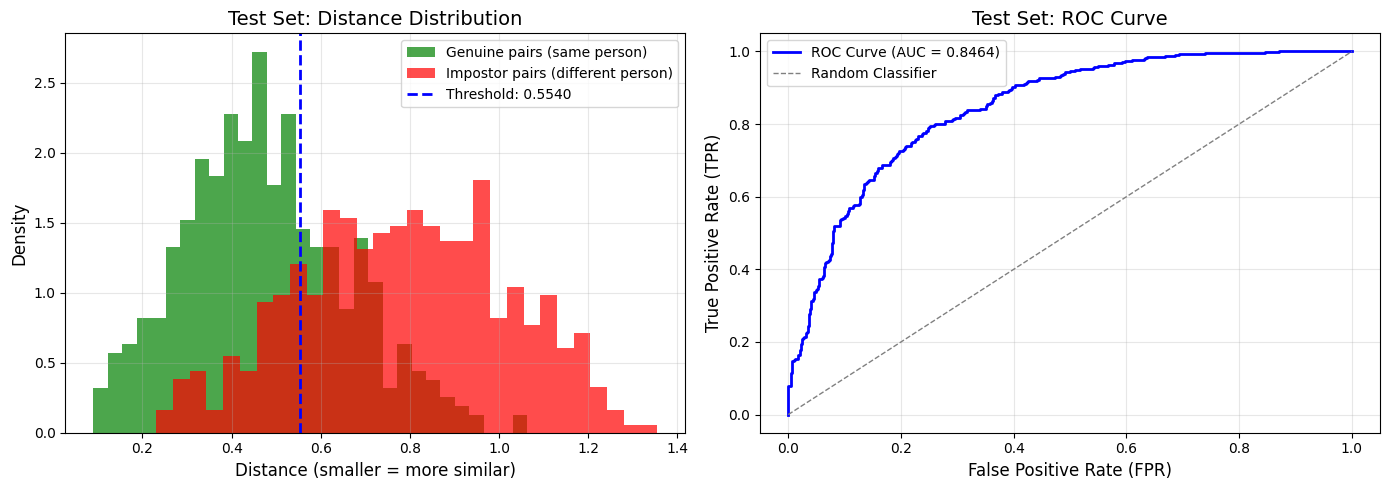


✓ Test set evaluation completed!


In [28]:
# ============================================
# Evaluate Matching Accuracy on Test Set (Verification Task)
# ============================================
# Use the same evaluation method as validation set
# This is a VERIFICATION task: given two images, determine if they are the same person
# Test set evaluation provides final performance metrics

if 'x_test' in globals() and x_test is not None and 'label_test' in globals() and label_test is not None:
    print("="*70)
    print("Evaluating Matching Accuracy on Test Set (Verification Task)")
    print("="*70)
    print(f"Test set size: {len(x_test)} samples")
    
    # Use the threshold from validation set evaluation if available
    if 'eval_results' in globals() and 'threshold' in eval_results:
        test_threshold = eval_results['threshold']
        print(f"Using threshold from validation set: {test_threshold:.4f}")
    else:
        test_threshold = None
        print("Will calculate optimal threshold from test set")
    
    # Run evaluation on test set (VERIFICATION task)
    test_eval_results = evaluate_contrastive_predictions(
        model, x_test, label_test, x_real, label_real_dict,
        threshold=test_threshold  # Use validation threshold or calculate new one
    )
    
    print("\n" + "="*70)
    print("Test Set Evaluation Summary (Verification Task)")
    print("="*70)
    print(f"Test Accuracy: {test_eval_results['accuracy']:.4f} ({test_eval_results['accuracy']*100:.2f}%)")
    print(f"Test TPR: {test_eval_results['tpr']:.4f}")
    print(f"Test TNR: {test_eval_results['tnr']:.4f}")
    print(f"Test FPR: {test_eval_results['fpr']:.4f}")
    print(f"Test FNR: {test_eval_results['fnr']:.4f}")
    print(f"Test Precision: {test_eval_results['precision']:.4f}")
    print(f"Test F1-Score: {test_eval_results['f1']:.4f}")
    print(f"Test ROC AUC: {test_eval_results['roc_auc']:.4f}")
    print("="*70)
    
    # Compare with validation set if available
    if 'eval_results' in globals():
        print("\n" + "="*70)
        print("Validation vs Test Set Comparison")
        print("="*70)
        print(f"{'Metric':<20} {'Validation':<15} {'Test':<15} {'Difference':<15}")
        print("-" * 70)
        print(f"{'Accuracy':<20} {eval_results['accuracy']:.4f} ({eval_results['accuracy']*100:.2f}%){'':<5} {test_eval_results['accuracy']:.4f} ({test_eval_results['accuracy']*100:.2f}%){'':<5} {test_eval_results['accuracy'] - eval_results['accuracy']:+.4f}")
        print(f"{'TPR':<20} {eval_results['tpr']:.4f}{'':<15} {test_eval_results['tpr']:.4f}{'':<15} {test_eval_results['tpr'] - eval_results['tpr']:+.4f}")
        print(f"{'TNR':<20} {eval_results['tnr']:.4f}{'':<15} {test_eval_results['tnr']:.4f}{'':<15} {test_eval_results['tnr'] - eval_results['tnr']:+.4f}")
        print(f"{'ROC AUC':<20} {eval_results['roc_auc']:.4f}{'':<15} {test_eval_results['roc_auc']:.4f}{'':<15} {test_eval_results['roc_auc'] - eval_results['roc_auc']:+.4f}")
    print("="*70)
    
    # Visualization: Distance distribution comparison
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Distance distribution
    axes[0].hist(test_eval_results['genuine_distances'], bins=30, alpha=0.7, 
                label='Genuine pairs (same person)', color='green', density=True)
    axes[0].hist(test_eval_results['impostor_distances'], bins=30, alpha=0.7, 
                label='Impostor pairs (different person)', color='red', density=True)
    axes[0].axvline(test_eval_results['threshold'], color='blue', linestyle='--', linewidth=2, 
                    label=f'Threshold: {test_eval_results["threshold"]:.4f}')
    axes[0].set_xlabel('Distance (smaller = more similar)', fontsize=12)
    axes[0].set_ylabel('Density', fontsize=12)
    axes[0].set_title('Test Set: Distance Distribution', fontsize=14)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: ROC Curve
    fpr_roc, tpr_roc, _ = roc_curve(test_eval_results['y_true'], -test_eval_results['y_pred'])
    axes[1].plot(fpr_roc, tpr_roc, color='blue', linewidth=2, 
                label=f'ROC Curve (AUC = {test_eval_results["roc_auc"]:.4f})')
    axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1, label='Random Classifier')
    axes[1].set_xlabel('False Positive Rate (FPR)', fontsize=12)
    axes[1].set_ylabel('True Positive Rate (TPR)', fontsize=12)
    axes[1].set_title('Test Set: ROC Curve', fontsize=14)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Test set evaluation completed!")
    
else:
    print("="*70)
    print("Test Set Not Available")
    print("="*70)
    print("Test set (x_test, label_test) is not loaded or is None.")
    print("Please run Cell 1 to load the test set first.")
    print("="*70)
